In [1]:
experiment_setup_name = "musicians_category_larger_memory"

In [2]:
import sys
sys.path.append("..")

In [3]:
#import everything in the world
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import theano
theano.config.floatX = 'float32'
theano.config.openmp = True
import theano.tensor as T
import lasagne
%load_ext autoreload
%autoreload 2
import pandas as pd
!mkdir ~/agentnet_snapshots


Couldn't import dot_parser, loading of dot files will not be possible.
mkdir: cannot create directory '/root/agentnet_snapshots': File exists


In [4]:
floatX = theano.config.floatX

from auxilary import _shared,set_shared,_in1d
from persistence import save,load


# Эта тетрадка рассказывает нелёгком пути обучения
* Recurrent Q-network 
* 1000 нейронов
* с epsilon-greedy обучением
* Тупой SGD с Nesterov Mommentum


Много вспомогательного кода

# Постановка задачи
* В начале сетке даётся некоторый человек, про которого она пока ничего не знает
* Человек - музыкант или околомузыкальная личность (с меньшей вероятностью - группа или... страна)
* Про человека известен некоторый набор фактов
 * факты типа "Известно, что" - за то, что какой-то аттрибут есть в его вики-карточке
   * например Nickname:is_known - есть прозвище, Died:is_known - есть дата смерти
 * Категориальные факты
   * инструменты, на которых играет человек
   * происхождение
   * декады активности
   * и т.п.


* За один шаг сетка может
 * сказать, что какой-то аттрибут про пользователя есть
   * например, Nickname:is_known - предположение, что у пользователя есть прозвище
   * если догадка верна, сеть получает положительное подкрепление ("конфетку")
   * если нет - отрицательное ("подзатыльник")
 * сказать "больше ничего не угадаю, несите следующего"
   * нулевое подкрепление
   * случайно выбирается следующий пользователь
  

# данные
* Всего в выборке 434 аттрибута
 * примеры аттрибутов в табе ниже
* В данном случае сеть обучается на чуть менее, чем 2500 случайных людей
* всего в выборке почти 100к людей/групп/всякого трэша

In [5]:
#вгрузим данные про кучу музыкантов 
#как оно собирается - ./data/preprocessing.ipynb
import pandas as pd
df = pd.DataFrame.from_csv("../data/musicians_categorized.csv")

0.0346481118134
(22612, 393)


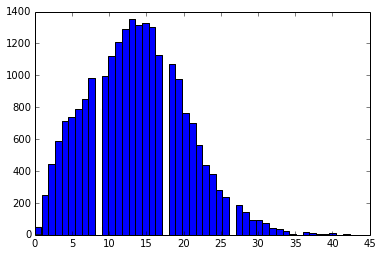

In [6]:
#гистограмма количества аттрибутов известных про музыканта
plt.hist((df.values).sum(axis=1),bins=50)
print (df.values).mean()
print df.shape

In [7]:
#отрежем тех, про кого известно менее 5 аттрибутов
df =  df[df.values.sum(axis=1) > 15]
print "всего самплов", df.shape

всего самплов (8594, 393)


In [8]:
from sklearn.cross_validation import train_test_split

In [9]:
#split categories and attributes
feature_names = df.columns
categorical_columns = np.nonzero(map(lambda s: s.startswith("category:"),feature_names))[0]
attribute_columns = np.nonzero(map(lambda s: not s.startswith("category:"),feature_names))[0]

data_cats = df.iloc[:,categorical_columns]
data_attrs = df.iloc[:,attribute_columns]



In [10]:
#поделим выборку
train_cats,test_cats,train_attrs,test_attrs = train_test_split(data_cats,data_attrs,test_size=0.99,random_state=42)
print "обучающая выборка:" ,len(train_attrs)
print "контрольная выборка:", len(test_attrs)

обучающая выборка: 85
контрольная выборка: 8509


# problem definition

Обучатор состоит из 2 частей
* "среды обучения"
* определятора полезностей
* самой нейронки

Среда обучения - такая штука, которая 
* подсовывает нейронке людей, 
 * каждый раз выбирается случайное подмножество людей 
   * (можно и 100 и 10 - просто не успел сравнить)
   * возвращает ответы на действия нейронки, попутно обновляя своё состояние
Определятор полезностей
* умеет считать полезность каждого действия по паре "состояние СРЕДЫ, действие агента ИЗ этого состояния"
* имеет функции для быстрого определения наград за все действия в сессиях

Нейронка будет далее по списку


__***для простоты, CategoryGuess будет имплементировать И среду И награждатор (см. класс ниже)***__

In [11]:
from objective import BaseObjective
from environment import BaseEnvironment

class CategoryGuess(BaseObjective,BaseEnvironment):
    def __init__(self,n_attrs,n_categories,batch_size=10):
        self._attributes = _shared("X_attrs_data",np.zeros([batch_size,n_attrs]),'uint8')
        self._categories =  _shared("categories_data",np.zeros([batch_size,n_categories]),'uint8')
        self._batch_size = _shared("batch_size_scalar",batch_size,'int32')
        
        _end_action = T.zeros([self._batch_size,1], dtype='uint8')
        
        self._joint_data = T.concatenate([self._attributes,
                                          self._categories,
                                          _end_action,
                                         ],axis=1).astype('float32')
    
        #indices
        self._category_action_ids = T.arange(
            self._attributes.shape[1],
            self._attributes.shape[1]+self._categories.shape[1]
        )
        
        self._end_action_id = self._joint_data.shape[1]-1
    def load_data_batch(self,attrs_batch,categories_batch):
        attrs_batch = np.array(attrs_batch)
        categories_batch = np.array(categories_batch)
        set_shared(self._attributes,attrs_batch)
        set_shared(self._categories,categories_batch)
        set_shared(self._batch_size,attrs_batch.shape[0])

    @property
    def n_actions(self):
        return int(self._joint_data.shape[1].eval())
    @property
    def observation_size(self):
        return int((self._joint_data.shape[1]+1).eval())
    @property
    def state_size(self):
        return int(self._joint_data.shape[1].eval())
    @property
    def batch_size(self):
        return int(self._batch_size.get_value())
    

    
    def get_first_state(self,batch_size=1):
        assert batch_size == self._joint_data.shape[0].eval()
        return T.zeros_like(self._joint_data,dtype='uint8') 
    
    
    def get_output_and_observation(self,last_state,action):
        
        #state is a boolean vector: whether or not i-th action
        #was tried already during this session
        #last output[:,end_code] always remains 1 after first being triggered
        
        
        batch_range = T.arange(action.shape[0])

        can_do_action = T.eq(last_state[:,self._end_action_id],0)
        
        state_after_action = T.set_subtensor(last_state[batch_range,action],1)
        
        new_state = T.switch(
            can_do_action.reshape([-1,1]),
            state_after_action,
            last_state
        )
        
        
        
        observation = T.concatenate([
                self._joint_data[batch_range,action,None],#uint8[batch,1]
                T.extra_ops.to_one_hot(action,self._joint_data.shape[1]),
            ],axis=1)
        
        return new_state, observation

    def get_reward(self,batch_i,session_states,session_actions):
        """
        WARNING! this runs on a single session, not on a batch
        reward given for taking the action in current environment state
        arguments:
            session_states float[batch_id, memory_id]: environment state before taking action
            session_actions int[batch_id]: agent action at this tick
        returns:
            reward float[batch_id]: reward for taking action from the given state
        """
        time_range = T.arange(session_actions.shape[0])
        

        _has_tried_already = session_states[time_range,session_actions]
        _session_is_active = T.eq(session_states[:,self._end_action_id],0)
        _has_finished_now = T.eq(session_actions,self._end_action_id)
        _action_is_categorical = _in1d(session_actions, self._category_action_ids)
        
        _response = self._joint_data[batch_i,session_actions].ravel()
        
        #categorical and attributes
        _reward_for_intermediate_action = T.switch(
            _action_is_categorical,
            _response*4-2,
            _response*2-1
        )
        #include end action
        _reward_for_action = T.switch(
            _has_finished_now,
            0,
            _reward_for_intermediate_action,
        )
        
        _reward_if_first_time = T.switch(
                _has_tried_already,
                0,
                _reward_for_action,
            )
        
        _final_reward = T.switch(
            _session_is_active,
            _reward_if_first_time,
            0,

            
        )
        
        
        return _final_reward.astype(floatX)

In [12]:
env = CategoryGuess(train_attrs.shape[1],train_cats.shape[1],5)

# agent setup
В свою очередь, нейронка состоит из 3 частей
* память агента
    * на вход получает пару (предыдущее состояние памятиа агента, сенсорная инфа о среде на ЭТОМ шагу)
    * определяет текущее состояние памяти агента (на том же шагу, что и сенсорная инф-ция со входа)
    * тут - GRUlayer, в потенциале - вообще что угодно, хоть 10 шагов LSTM за 1 раз
       * какой именно GRUlayer:
       * Reset gate - dense w/ expit
       * Update gate - dense w/ expit
       * Hidden update gate - dense w/ tanh

* определятор Q-значений
    * на вход получает память агента
    * определяет Q_значения каждого действия
    * тут - DenseLayer, потенциал - что угодно
* приниматор решений по Q-значениям
    * на вход получает Q-значения для действий
    * определяет, как вывод нейронки трансформируется в решение,
    * формат выхода - целые числа - номера выбранных действий
     * тут - с вероятностью epsilon берётся решение, 
       * которому предсказана наибольшая полезность
       * иначе берётся случайное равновероятное
     * альтернативный вариант - решения выбираются с веростностями
       * $Pi(a) = softmax(Qi(a)) = {e^{Qi(x)}} / {\sum\limits_{j=1}^n e^{Qj(X)}}$ 
       * где Q(a) - предсказанная полезность действия a
* всё это делается векторизованно для батча произвольной размерности


### Agent - просто обёртка над этими 3 пунктами
* строго говоря, можно воткнуть любую нейронку, которая мапает 
* `float last_agent_state[batch,units], float observation[batch,sensors] ->`
* `-> float new_agent_state[batch,units], float qvalues[batch,actions], int actions[batch]`


In [13]:
from resolver import EpsilonGreedyResolver
from memory import GRUMemoryLayer
from agent import Agent

In [14]:
import lasagne

n_hid=1024


_observation_layer = lasagne.layers.InputLayer([None,env.observation_size],name="obs_input")
_prev_state_layer = lasagne.layers.InputLayer([None,n_hid],name="prev_state_input")
#memory
gru = GRUMemoryLayer(n_hid,
                     _observation_layer,
                     _prev_state_layer,
                     name="gru0")

#q_eval
q_eval = lasagne.layers.DenseLayer(gru,num_units = env.n_actions,
                                   nonlinearity=lasagne.nonlinearities.linear,name="QEvaluator")
#resolver
epsilon = _shared("e-greedy.epsilon",0.9,dtype=floatX)

resolver = EpsilonGreedyResolver(q_eval,epsilon=epsilon,name="resolver")


#all together
agent = Agent(gru,q_eval,resolver)


In [15]:
history = agent.get_sessions(env,session_length=20,
                       batch_size=env._joint_data.shape[0],
                       initial_env_state=env.get_first_state(env.batch_size))
state_seq,observation_seq,hidden_seq,qvalues_seq,action_seq = history

rewards_seq = env.get_reward_sequences(state_seq,action_seq)


In [16]:
get_history = theano.function([],history+(rewards_seq,),mode=theano.compile.mode.FAST_RUN)



# weights
* вот так нахаляву можно вытащить ВСЕ веса нейронок агента
* что НЕ вытаскивается 
 * архитектура сети
 * гиперпараметры (жадность, gamma)
 * состояния среды/наблюдения
* короче, вытаскиваются только "нейронячие" параметры
* хочешь, чтобы в твоём слое вытащилась какая-то shared переменная - добавь её в параметры слоя [с каким-ть тэгом, если хочешь]
* всё как в ванильной лазанье

In [17]:
#all trainable weights
weights = lasagne.layers.get_all_params(resolver,trainable=True)
weights

[gru0.W_in_to_updategate,
 gru0.W_hid_to_updategate,
 gru0.b_updategate,
 gru0.W_in_to_resetgate,
 gru0.W_hid_to_resetgate,
 gru0.b_resetgate,
 gru0.W_in_to_hidden_update,
 gru0.W_hid_to_hidden_update,
 gru0.b_hidden_update,
 QEvaluator.W,
 QEvaluator.b]

In [18]:
#all weights but for Qvalues prediciton ones (not to penalize q-predictors by l2)
weights_inner = filter(lambda w: "QEvaluator" not in w.name,weights)
weights_inner

[gru0.W_in_to_updategate,
 gru0.W_hid_to_updategate,
 gru0.b_updategate,
 gru0.W_in_to_resetgate,
 gru0.W_hid_to_resetgate,
 gru0.b_resetgate,
 gru0.W_in_to_hidden_update,
 gru0.W_hid_to_hidden_update,
 gru0.b_hidden_update]

# целевая функция для обучения сети

* Интуитивно, цель - предсказывать Q-значения (полезности) действий
* $Q(s,a) = R(s,a) + gamma* Max_{a'}{ Q(s',a')}  $
 * R(s,a) - непосредственная награда за действие (+5 если угадал, -1 если нет и т.п.)
 * s' - состояние, в которое агент попал, сделав действие a из состояния s
 * a' - действие, которое можно совершить в состоянии s'
 * gamma - во сколько раз награда/пинок через 1 шаг менее значимы, чем сейчас
 * интуиция - "в состоянии s полезность действия a - это непосредственная печенька за это действие ПЛЮС все печеньки, которые можно собрать, если после этого действия вести себя оптимально"
 
* В реальном мире оптимизируются попарно 2 приближения этой функции
* $ RMSE_{reccurent}: (NN_s(a) - (R + gamma* Max_a'{ NN_s'(a')})^2$
 * NN_s(a) предсказаннная из состояния s полезност Q(s,a)
 * считается для тех NN_s(a), которые агент совершил
 * NN_s'(a') - полезности всех действий сразу после совершения a из состяния s

* $ RMSE_{naive}: (NN_s(a^*) - (R + gamma*  NN_s'(a'^*))^2$
 * аналогично предыдущему, но a* - реально совершённое агентом действие
 * оценка смещена, но куда проще оптимизируется, чем предыдущая
   * по крайней мере, с softmax принятием решений

In [19]:
is_alive_seq = T.eq(state_seq[:,:,-1],0)

#gamma - delayed reward coefficient - what fraction of reward is retained if it is obtained one tick later
gamma = _shared('q_learning_gamma',np.float32(0.95),floatX)


ref_tuples = env.get_reference_tuples(qvalues_seq,action_seq,rewards_seq,is_alive_seq,gamma_or_gammas=gamma,)

action_ids_ravel,immediate_rewards_ravel, predicted_Qvalues_ravel,reference_Qvalues_ravel,is_end_ravel= ref_tuples

from auxilary import consider_constant
reference_Qvalues_ravel = consider_constant(reference_Qvalues_ravel)

predicted_Qvalues_for_actions_ravel = predicted_Qvalues_ravel[T.arange(action_ids_ravel.shape[0]),action_ids_ravel]


In [20]:
loss_recurrent = lasagne.objectives.squared_error(reference_Qvalues_ravel,predicted_Qvalues_for_actions_ravel).mean()

In [21]:
weight_ravel = T.concatenate([w.ravel() for w in weights_inner])
reg_l2 = reg_l2 = T.mean(weight_ravel**2)*0.1


In [22]:
loss = loss_recurrent + reg_l2

# алгоритм обучения
* обучаются все параметры обычным Stochastic Gradient Descent с Nestrov Mommentum
* регуляризации нет, ибо пока не понадобилась

In [23]:
_updates = lasagne.updates.nesterov_momentum(loss,
                                             weights,learning_rate=0.005,momentum=0.5)
#updates = lasagne.updates.sgd(loss_recurrent,weights,0.1)

In [24]:
mean_session_reward = immediate_rewards_ravel.sum()/ rewards_seq.shape[0]
train_fun = theano.function([],[loss,loss_recurrent,reg_l2,mean_session_reward],updates=_updates)
loss_fun = theano.function([],[loss,loss_recurrent,reg_l2,mean_session_reward])

# evaluation
* удобная [мне одному] функция, которая показывает примеры сессий и внутреннее состояние нейронки
* текстовая часть - 
    * #(номер_действия) (имя_действия) (предсказанное_Qvalue) -> (награда) | следующая итерация
* картинка (если display = True)
    * X - моменты времени, Y - попугаи
    * жЫрные линии - Q-значения категорий
    * тонкие линии - Q-значения узнавания аттрибутов
    * точки на линиях - выбранные действия
    * пунктирные линии - активация нейронов в памяти агента
    * синяя черта (тонкая, вертикальная) - конец сессии (действие или лимит времени)


In [25]:
evaluation_fun = theano.function([],[action_ids_ravel,predicted_Qvalues_for_actions_ravel,immediate_rewards_ravel,
                                     reference_Qvalues_ravel,is_end_ravel,
                                     hidden_seq,qvalues_seq,action_seq])


In [26]:
#new names order
feature_names = list(data_attrs.columns) + list(data_cats.columns) + ["<end_session_action>"]
is_categorical = lambda i: feature_names[i].startswith("category:")

def print_session(n_sessions = 3,display=False,legend=True):
    
    a_lot_of_data = evaluation_fun()    
    actions,qvalues,rewards,ref_qvalues,end_sel = a_lot_of_data[:5]
    hidden_log,qvalues_log,action_log = a_lot_of_data[5:]
    
    
    
    b_i = 0 #batch iter ~ session iter
    t_i = 0 #time iter
    

    for a,q,r,q_ref,is_end in zip(actions,qvalues,rewards,ref_qvalues,end_sel):
        print "#%i: %s (%.3f) -> %s |"%(a,feature_names[a],q, r,),
        
        
        t_i +=1
        if is_end ==1:
            
            print '<end>'
            print 'true:',
            for cat in env._categories.get_value()[b_i].nonzero()[0]:
                print feature_names[cat+env._attributes.shape[1].eval()],
            print
                
            #plot qvalues
            if display:
                plt.figure(figsize=[16,8])

                q_values = qvalues_log[b_i].T
                for i in range(q_values.shape[0]):
                    plt.plot(q_values[i],label=feature_names[i],linewidth = 1 + 4*is_categorical(i))

                hidden_activity =  hidden_log[b_i].T
                for i, hh in enumerate(hidden_activity):
                    plt.plot(hh,'--',label='n'+str(i))
                    
                session_actions = action_log[b_i,:t_i]
                action_range = np.arange(len(session_actions))
                plt.scatter(action_range, qvalues_log[b_i][action_range, session_actions])


                #session end
                plt.plot(np.repeat(t_i-1,2),np.linspace(-0.5,0.5,2))
                plt.xlim(0,max(t_i*1.1,2))
                plt.xticks(np.arange(t_i))
                plt.grid()
                if legend:
                    plt.legend()
                plt.show()
                
            print
            #/
            b_i +=1
            t_i = 0

            if b_i >= n_sessions:
                break


# training

In [27]:
def load_random_batch(env,attrs,cats,batch_size=10):
    
    attrs,cats = np.array(attrs),np.array(cats)
    
    assert len(attrs) == len(cats)
    batch_ids = np.random.randint(0,len(attrs),batch_size)
    env.load_data_batch(attrs[batch_ids],cats[batch_ids])

In [28]:
from collections import defaultdict

epoch_counter = 1
score_log = defaultdict(dict) #{metric_name: {epoch:value} }

def plot_scores(title="metrics"):
    plt.figure(figsize=[10,10])
    plt.title("metrics history")
    for metric_name, metric_dict in score_log.items():            
        plt.plot(*zip(*sorted(metric_dict.items())),label = metric_name)

    plt.title(title)
    plt.grid()
    plt.legend(loc='lower right')
    plt.show()


In [ ]:
alpha = 0.1
ma_reward = 0.
ma_reward_greedy = 0.

# само обучение
* шаг алгоритма - 
 * выбрать B случайных людей
 * пересчитать "жадность" алгоритма (чем дальше, тем более жадный)
 * сделать шаг обучения
 * раз в M итераций - добавить точку на график обучения по 3 метрикам
   * ожидание награды за сессию при текущей жадности на тренировочных данных
   * то же самое при максимальной жадности
 * раз в N итераций - 
   * показать несколько примеров сессий на обучающих данных при разной жадности
   * показать графики обучения
 * раз в K итераций - записать веса нейронки в файл (snapshot)

epoch 25700,loss 0.18047, greed 0.85101, rewards: ( train 2.23264, det_train 3.11401) 
rec 0.179 reg 0.001
epoch 25800,loss 1.02224, greed 0.85226, rewards: ( train 1.15552, det_train 3.20261) 
rec 1.021 reg 0.001
epoch 25900,loss 0.29545, greed 0.85349, rewards: ( train 1.17882, det_train 3.08235) 
rec 0.294 reg 0.001
Evaluation:

deterministic
#260: decades_active:1990 (1.953) -> 1.0 | #26: decades_active:2010 (1.915) -> 1.0 | #25: last_activity:still_active (1.197) -> 1.0 | #26: decades_active:2010 (0.202) -> 0.0 | #393: <end_session_action> (0.030) -> 0.0 | <end>
true: category:List_of_Maryland_music_people category:List_of_rhythm_guitarists


current_greediness (0.854721)
#254: Genres:big (0.540) -> -1.0 | #166: decades_active:2000 (1.718) -> 1.0 | #26: decades_active:2010 (1.994) -> 1.0 | #25: last_activity:still_active (1.531) -> 1.0 | #260: decades_active:1990 (0.306) -> 1.0 | #392: category:List_of_rhythm_guitarists (-1.950) -> 2.0 | #25: last_activity:still_active (0.080) -> 

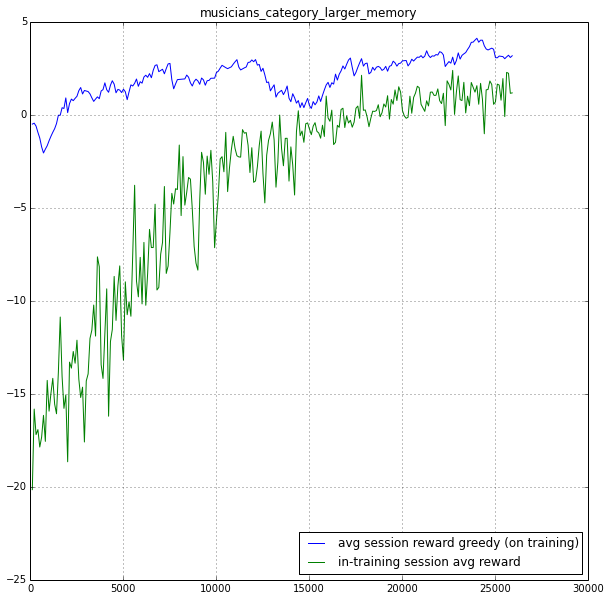

epoch 26000,loss 0.12378, greed 0.85472, rewards: ( train 0.75555, det_train 3.17411) 
rec 0.123 reg 0.001
epoch 26100,loss 0.27886, greed 0.85594, rewards: ( train 2.28811, det_train 3.15670) 
rec 0.278 reg 0.001
epoch 26200,loss 0.86388, greed 0.85716, rewards: ( train 2.03455, det_train 3.24103) 
rec 0.863 reg 0.001
epoch 26300,loss 1.25766, greed 0.85837, rewards: ( train 2.14100, det_train 3.11693) 
rec 1.257 reg 0.001
epoch 26400,loss 0.07531, greed 0.85958, rewards: ( train 1.99615, det_train 2.90524) 
rec 0.074 reg 0.001
epoch 26500,loss 0.11367, greed 0.86078, rewards: ( train 2.61644, det_train 3.01471) 
rec 0.113 reg 0.001
epoch 26600,loss 0.14065, greed 0.86197, rewards: ( train 1.84213, det_train 3.11324) 
rec 0.140 reg 0.001
epoch 26700,loss 0.21102, greed 0.86316, rewards: ( train 2.18219, det_train 3.30192) 
rec 0.210 reg 0.001
epoch 26800,loss 0.16943, greed 0.86434, rewards: ( train 2.83732, det_train 3.47173) 
rec 0.168 reg 0.001
epoch 26900,loss 0.96163, greed 0.865

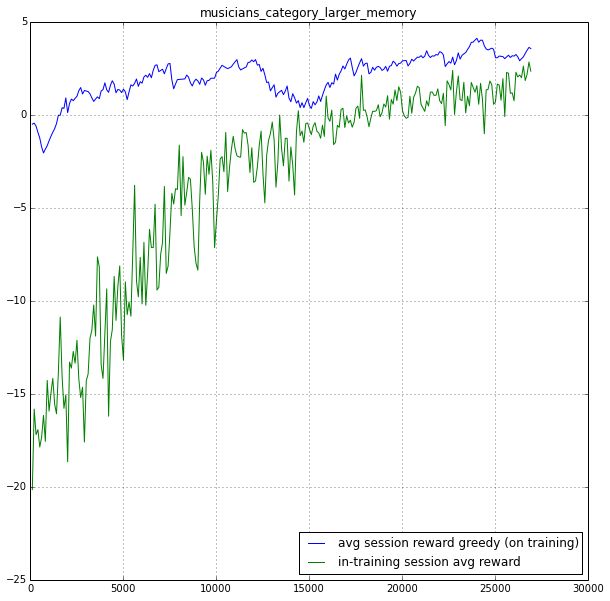

epoch 27000,loss 0.17341, greed 0.86668, rewards: ( train 1.31596, det_train 3.56210) 
rec 0.172 reg 0.001
epoch 27100,loss 1.12382, greed 0.86785, rewards: ( train 2.50269, det_train 3.50589) 
rec 1.123 reg 0.001
epoch 27200,loss 0.42562, greed 0.86901, rewards: ( train 1.54842, det_train 3.35530) 
rec 0.425 reg 0.001
epoch 27300,loss 1.62514, greed 0.87016, rewards: ( train 3.10724, det_train 3.41977) 
rec 1.624 reg 0.001
epoch 27400,loss 0.12093, greed 0.87130, rewards: ( train 2.01570, det_train 3.57779) 
rec 0.120 reg 0.001
epoch 27500,loss 0.96151, greed 0.87244, rewards: ( train 2.18355, det_train 3.72001) 
rec 0.961 reg 0.001
epoch 27600,loss 1.81866, greed 0.87358, rewards: ( train 2.40535, det_train 3.64801) 
rec 1.818 reg 0.001
epoch 27700,loss 0.17090, greed 0.87471, rewards: ( train 2.65346, det_train 3.38321) 
rec 0.170 reg 0.001
epoch 27800,loss 0.55665, greed 0.87583, rewards: ( train 2.61357, det_train 3.54489) 
rec 0.556 reg 0.001
epoch 27900,loss 0.25098, greed 0.876

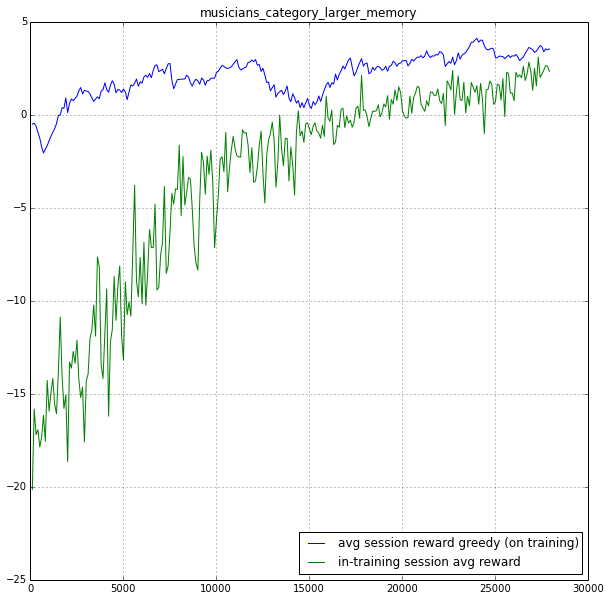

epoch 28000,loss 0.32637, greed 0.87806, rewards: ( train 2.32223, det_train 3.54136) 
rec 0.325 reg 0.001
epoch 28100,loss 1.14482, greed 0.87917, rewards: ( train 2.38188, det_train 3.48722) 
rec 1.144 reg 0.001
epoch 28200,loss 0.21564, greed 0.88027, rewards: ( train 2.38962, det_train 3.33850) 
rec 0.215 reg 0.001
epoch 28300,loss 0.15493, greed 0.88137, rewards: ( train 2.87645, det_train 3.50465) 
rec 0.154 reg 0.001
epoch 28400,loss 0.57903, greed 0.88246, rewards: ( train 1.76844, det_train 3.65419) 
rec 0.578 reg 0.001
epoch 28500,loss 0.49565, greed 0.88354, rewards: ( train 2.39707, det_train 3.58877) 
rec 0.495 reg 0.001
epoch 28600,loss 0.30878, greed 0.88462, rewards: ( train 2.86159, det_train 3.72989) 
rec 0.308 reg 0.001
epoch 28700,loss 1.39663, greed 0.88570, rewards: ( train 2.69601, det_train 3.85690) 
rec 1.396 reg 0.001
epoch 28800,loss 0.29593, greed 0.88677, rewards: ( train 3.39436, det_train 3.57121) 
rec 0.295 reg 0.001
epoch 28900,loss 0.23803, greed 0.887

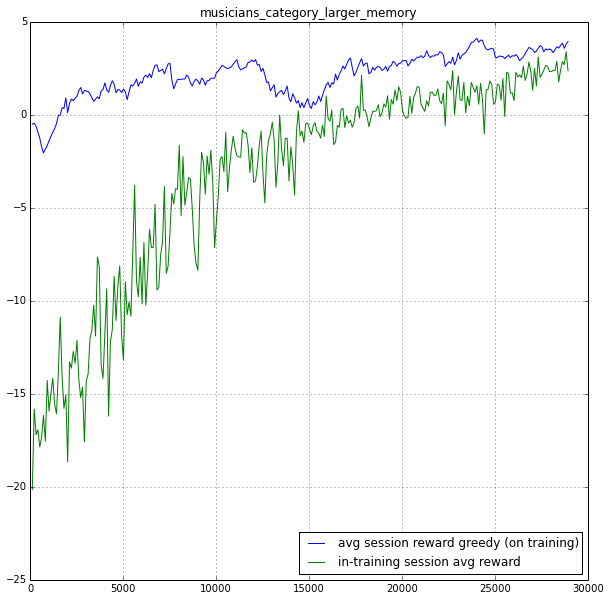

epoch 29000,loss 0.30558, greed 0.88889, rewards: ( train 2.86591, det_train 3.93268) 
rec 0.305 reg 0.001
epoch 29100,loss 0.13911, greed 0.88994, rewards: ( train 2.60238, det_train 4.03941) 
rec 0.138 reg 0.001
epoch 29200,loss 0.41893, greed 0.89099, rewards: ( train 2.47775, det_train 4.13547) 
rec 0.418 reg 0.001
epoch 29300,loss 0.43281, greed 0.89203, rewards: ( train 2.36014, det_train 4.12192) 
rec 0.432 reg 0.001
epoch 29400,loss 0.76952, greed 0.89307, rewards: ( train 1.87683, det_train 4.10973) 
rec 0.769 reg 0.001
epoch 29500,loss 0.40707, greed 0.89410, rewards: ( train 2.93936, det_train 3.69876) 
rec 0.406 reg 0.001
epoch 29600,loss 0.37881, greed 0.89513, rewards: ( train 1.76411, det_train 3.72888) 
rec 0.378 reg 0.001
epoch 29700,loss 0.10201, greed 0.89615, rewards: ( train 2.61574, det_train 3.75599) 
rec 0.101 reg 0.001
epoch 29800,loss 0.11574, greed 0.89716, rewards: ( train 2.93901, det_train 3.78040) 
rec 0.115 reg 0.001
epoch 29900,loss 1.39014, greed 0.898

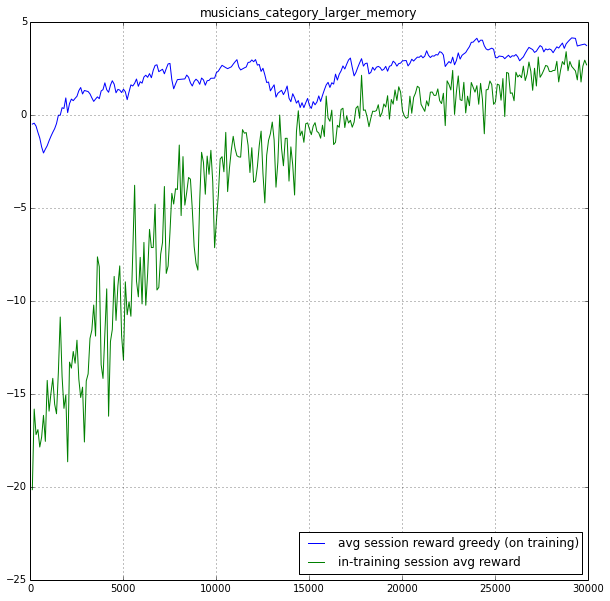

snapshot saved
epoch 30000,loss 0.70247, greed 0.89918, rewards: ( train 3.46953, det_train 3.72212) 
rec 0.701 reg 0.001
epoch 30100,loss 0.61242, greed 0.90018, rewards: ( train 2.87503, det_train 3.94991) 
rec 0.611 reg 0.001
epoch 30200,loss 0.22885, greed 0.90118, rewards: ( train 3.64947, det_train 4.05492) 
rec 0.228 reg 0.001
epoch 30300,loss 0.44155, greed 0.90217, rewards: ( train 3.14181, det_train 4.24943) 
rec 0.441 reg 0.001
epoch 30400,loss 0.08825, greed 0.90316, rewards: ( train 2.61380, det_train 4.22448) 
rec 0.087 reg 0.001
epoch 30500,loss 0.43945, greed 0.90414, rewards: ( train 3.02234, det_train 4.30203) 
rec 0.438 reg 0.001
epoch 30600,loss 1.34415, greed 0.90512, rewards: ( train 2.18775, det_train 4.47183) 
rec 1.343 reg 0.001
epoch 30700,loss 0.05876, greed 0.90609, rewards: ( train 2.87765, det_train 3.92465) 
rec 0.058 reg 0.001
epoch 30800,loss 0.03542, greed 0.90706, rewards: ( train 2.43043, det_train 3.93218) 
rec 0.034 reg 0.001
epoch 30900,loss 1.325

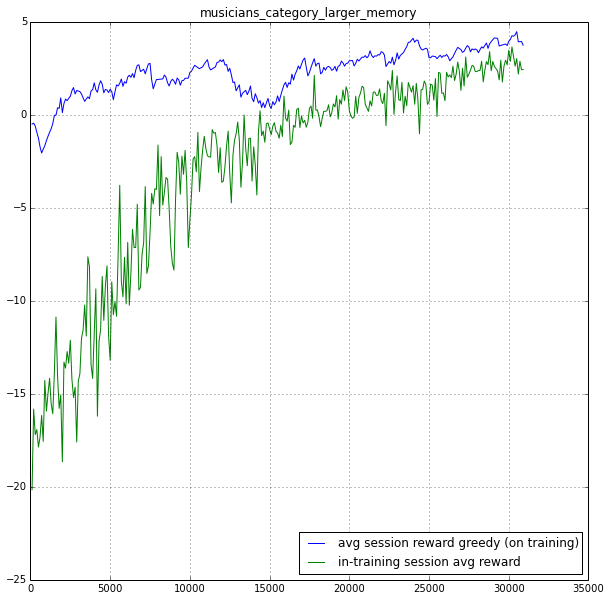

epoch 31000,loss 0.35733, greed 0.90898, rewards: ( train 1.52139, det_train 3.74507) 
rec 0.356 reg 0.001
epoch 31100,loss 0.10426, greed 0.90993, rewards: ( train 2.69735, det_train 3.67056) 
rec 0.103 reg 0.001
epoch 31200,loss 0.15969, greed 0.91088, rewards: ( train 2.86610, det_train 3.80351) 
rec 0.159 reg 0.001
epoch 31300,loss 0.30401, greed 0.91182, rewards: ( train 3.06985, det_train 3.92315) 
rec 0.303 reg 0.001
epoch 31400,loss 1.05638, greed 0.91276, rewards: ( train 3.41956, det_train 4.13084) 
rec 1.055 reg 0.001
epoch 31500,loss 0.11859, greed 0.91369, rewards: ( train 1.88955, det_train 3.91776) 
rec 0.118 reg 0.001
epoch 31600,loss 0.16958, greed 0.91462, rewards: ( train 2.98212, det_train 4.02598) 
rec 0.169 reg 0.001
epoch 31700,loss 1.24993, greed 0.91555, rewards: ( train 2.69642, det_train 4.22338) 
rec 1.249 reg 0.001
epoch 31800,loss 0.25703, greed 0.91647, rewards: ( train 3.76787, det_train 4.10104) 
rec 0.256 reg 0.001
epoch 31900,loss 0.60225, greed 0.917

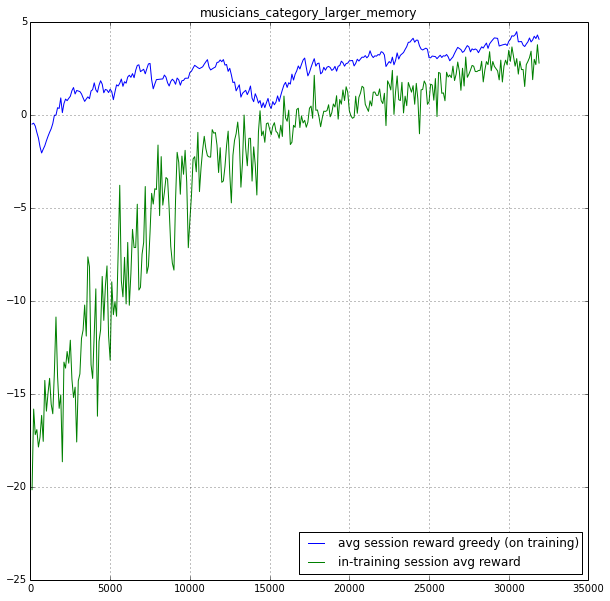

epoch 32000,loss 0.28715, greed 0.91829, rewards: ( train 2.75154, det_train 4.06185) 
rec 0.286 reg 0.001
epoch 32100,loss 0.43150, greed 0.91920, rewards: ( train 3.79144, det_train 4.05566) 
rec 0.430 reg 0.001
epoch 32200,loss 1.73734, greed 0.92010, rewards: ( train 2.27210, det_train 4.15009) 
rec 1.736 reg 0.001
epoch 32300,loss 0.04827, greed 0.92100, rewards: ( train 3.50166, det_train 3.33509) 
rec 0.047 reg 0.001
epoch 32400,loss 0.16108, greed 0.92189, rewards: ( train 2.58731, det_train 3.50158) 
rec 0.160 reg 0.001
epoch 32500,loss 0.19560, greed 0.92278, rewards: ( train 3.51646, det_train 3.75142) 
rec 0.195 reg 0.001
epoch 32600,loss 0.06728, greed 0.92366, rewards: ( train 3.36740, det_train 3.97628) 
rec 0.066 reg 0.001
epoch 32700,loss 0.11903, greed 0.92454, rewards: ( train 3.51562, det_train 4.07865) 
rec 0.118 reg 0.001
epoch 32800,loss 0.34530, greed 0.92542, rewards: ( train 2.57974, det_train 4.27078) 
rec 0.344 reg 0.001
epoch 32900,loss 0.24261, greed 0.926

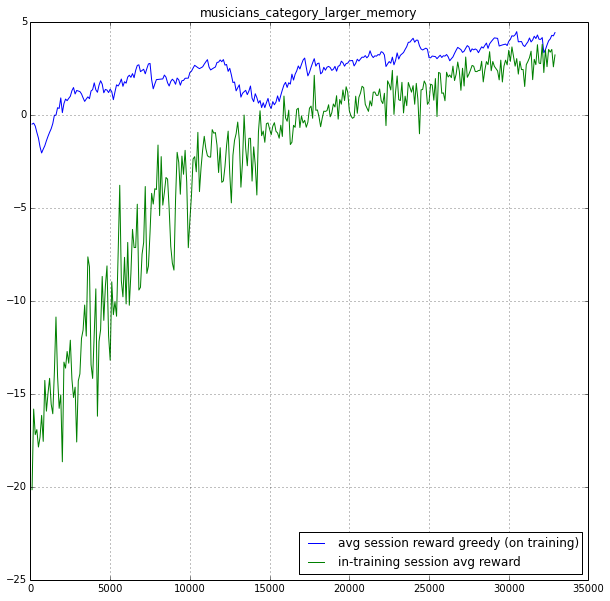

epoch 33000,loss 1.02573, greed 0.92716, rewards: ( train 2.35760, det_train 4.41934) 
rec 1.025 reg 0.001
epoch 33100,loss 1.37641, greed 0.92802, rewards: ( train 2.93577, det_train 4.07740) 
rec 1.375 reg 0.001
epoch 33200,loss 0.15753, greed 0.92887, rewards: ( train 4.06199, det_train 3.86966) 
rec 0.157 reg 0.001
epoch 33300,loss 0.16916, greed 0.92973, rewards: ( train 3.50506, det_train 4.08270) 

In [ ]:
n_epochs = 25000
batch_size=1
for i in range(n_epochs):
    
    resolver.rng.seed(epoch_counter)
    
    creeping_greed = min(0.1 + (1.-np.exp(-epoch_counter/20000.)*0.9),0.95)
    creeping_epsilon = 1.-creeping_greed
    
    
    #train
    load_random_batch(env,train_attrs,train_cats,batch_size=batch_size)
    
    loss,q_loss,reg_loss,avg_reward = train_fun()
    
    
    
    #reward loss moving average
    ma_reward = alpha*avg_reward+ (1-alpha)*ma_reward
    
    
    
    
    if epoch_counter%1000==0:
        print "Evaluation:"
        print '\ndeterministic'
        set_shared(resolver.epsilon,0)
        print_session(1)
        
        
        
        print '\ncurrent_greediness (%f)'%creeping_greed
        set_shared(resolver.epsilon,creeping_epsilon)
        print_session(1)
        
        plot_scores(experiment_setup_name)

    if epoch_counter% 5000 ==0:
        save(resolver,"/root/agentnet_snapshots/{}.epoch{}.pcl".format(experiment_setup_name,epoch_counter))
        print "snapshot saved"
        
        


    if epoch_counter%100 ==0:
        print "epoch %i,loss %.5f, greed %.5f, rewards: ( train %.5f, det_train %.5f) "%(
            epoch_counter,loss,creeping_greed,ma_reward,ma_reward_greedy)
        print "rec %.3f reg %.3f"%(q_loss,reg_loss)
        
        score_log["in-training session avg reward"][epoch_counter] = ma_reward
        
        
        
        #greedy train
        set_shared(resolver.epsilon,0)
        avg_reward_greedy = loss_fun()[-1]
        ma_reward_greedy = (1-alpha)*ma_reward_greedy + alpha*avg_reward_greedy
        score_log["avg session reward greedy (on training)"][epoch_counter] = ma_reward_greedy
        
        
        #back to epsilon-greedy
        set_shared(resolver.epsilon,creeping_epsilon)


        
        
    epoch_counter  +=1


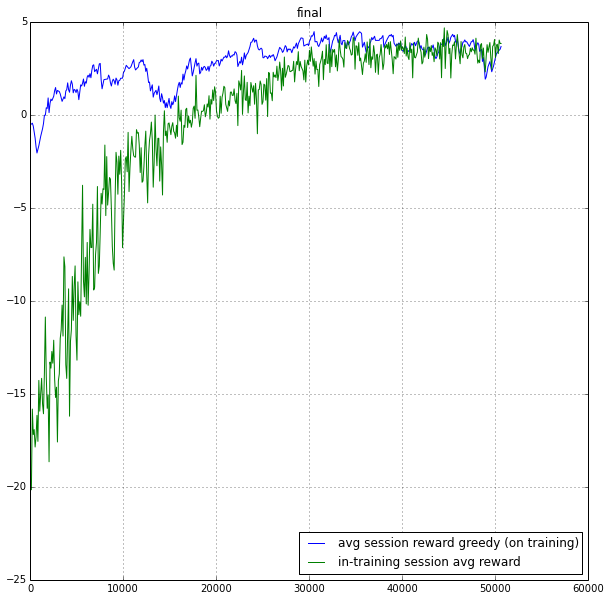

In [46]:
plot_scores("final")#last stage

In [45]:
load_random_batch(env,train_attrs,train_cats,batch_size=10)
print_session(10)

#260: decades_active:1990 (3.639) -> -1.0 | #166: decades_active:2000 (2.098) -> -1.0 | #1: Birth name:is_known (2.214) -> 1.0 | #149: Labels:is_known (0.886) -> 1.0 | #393: <end_session_action> (0.000) -> 0.0 | <end>
true: category:List_of_country_performers_by_era category:List_of_country_music_performers category:List_of_blues_musicians category:List_of_singer-songwriters

#260: decades_active:1990 (3.639) -> 1.0 | #166: decades_active:2000 (3.529) -> 1.0 | #26: decades_active:2010 (2.610) -> 1.0 | #25: last_activity:still_active (1.735) -> 1.0 | #149: Labels:is_known (0.687) -> 1.0 | #393: <end_session_action> (-0.007) -> 0.0 | <end>
true:

#233: Genres:blues (0.892) -> -1.0 | #260: decades_active:1990 (3.748) -> -1.0 | #166: decades_active:2000 (2.286) -> 1.0 | #26: decades_active:2010 (2.360) -> 1.0 | #25: last_activity:still_active (1.553) -> 1.0 | #25: last_activity:still_active (0.604) -> 0.0 | #149: Labels:is_known (0.424) -> 1.0 | #393: <end_session_action> (0.017) -> 0.0 | 

#260: decades_active:1990 (3.639) -> -1.0 | #166: decades_active:2000 (2.098) -> -1.0 | #1: Birth name:is_known (2.214) -> 1.0 | #149: Labels:is_known (0.886) -> 1.0 | #393: <end_session_action> (0.000) -> 0.0 | <end>
true: category:List_of_country_performers_by_era category:List_of_country_music_performers category:List_of_blues_musicians category:List_of_singer-songwriters


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


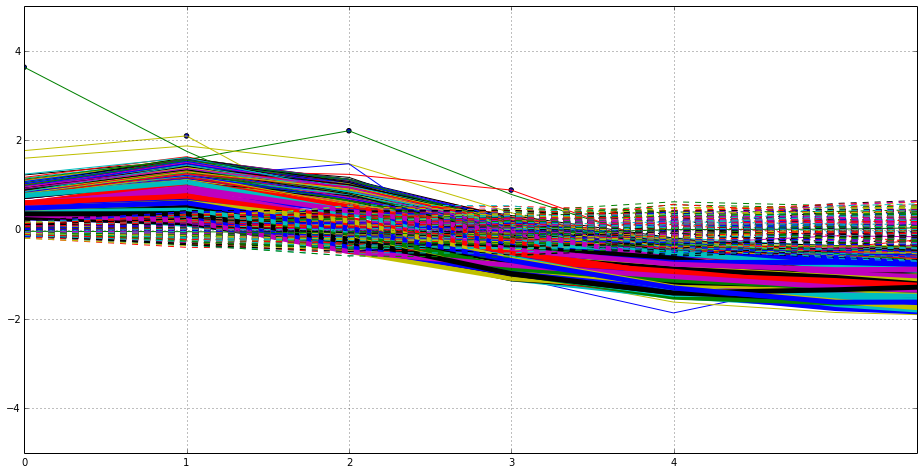


#260: decades_active:1990 (3.639) -> 1.0 | #166: decades_active:2000 (3.529) -> 1.0 | #26: decades_active:2010 (2.610) -> 1.0 | #25: last_activity:still_active (1.735) -> 1.0 | #149: Labels:is_known (0.687) -> 1.0 | #393: <end_session_action> (-0.007) -> 0.0 | <end>
true:


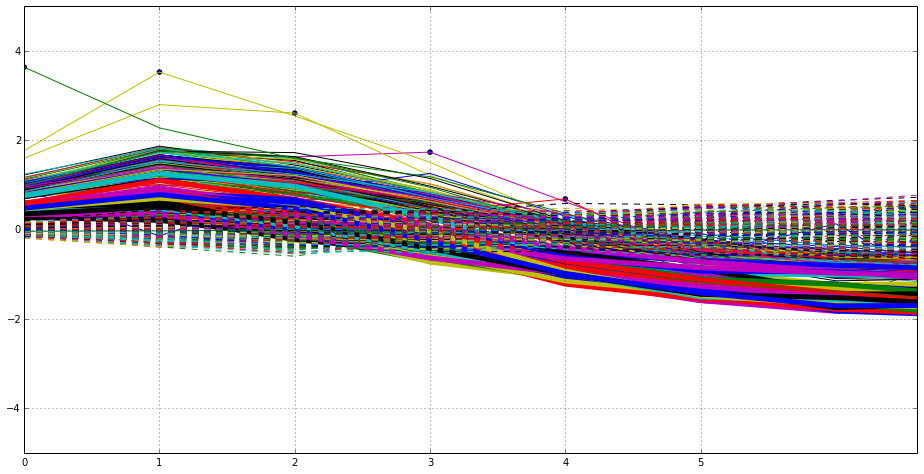


#260: decades_active:1990 (3.639) -> -1.0 | #166: decades_active:2000 (2.098) -> 1.0 | #26: decades_active:2010 (2.528) -> 1.0 | #25: last_activity:still_active (1.586) -> 1.0 | #25: last_activity:still_active (0.558) -> 0.0 | #149: Labels:is_known (0.311) -> 1.0 | #393: <end_session_action> (0.018) -> 0.0 | <end>
true: category:List_of_girl_groups category:List_of_lead_vocalists


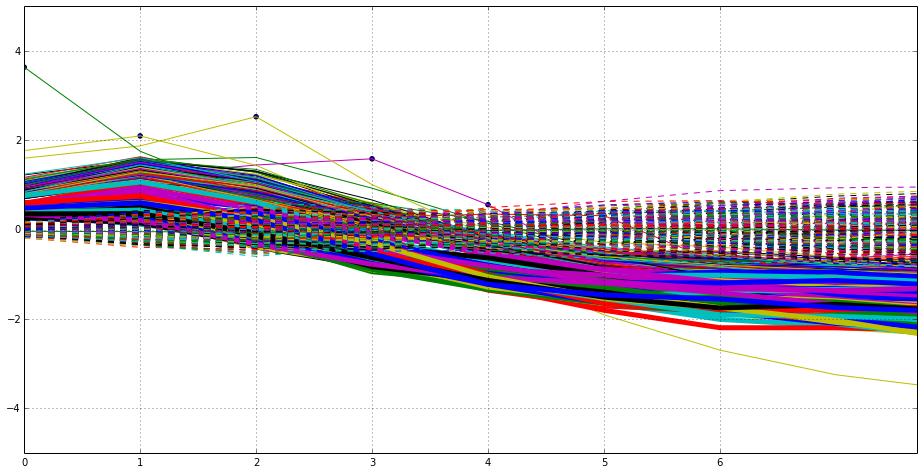

In [47]:
print_session(display=True,legend=False)